In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from scipy.stats import norm
import matplotlib.pyplot as plt

## Question 1: Transform Training Data

Transformation Function for Gaussian RBF

In [2]:
def GaussianRBF(X, size=10, a=0, b=1, var=0.1, biases=False):
    means = np.linspace(a, b, size)
    A = np.zeros(shape=(X.shape[0], means.shape[0]))
    for i, x in enumerate(X):
        A = A.at[i, :].set([np.exp((-0.5) * ((x-mu)/var)**2).item() for mu in means])
    if biases:
        bias_col = np.ones(shape=X.shape[0])
        A = np.hstack((bias_col[:, None], A))
    return A

Generate Training Data


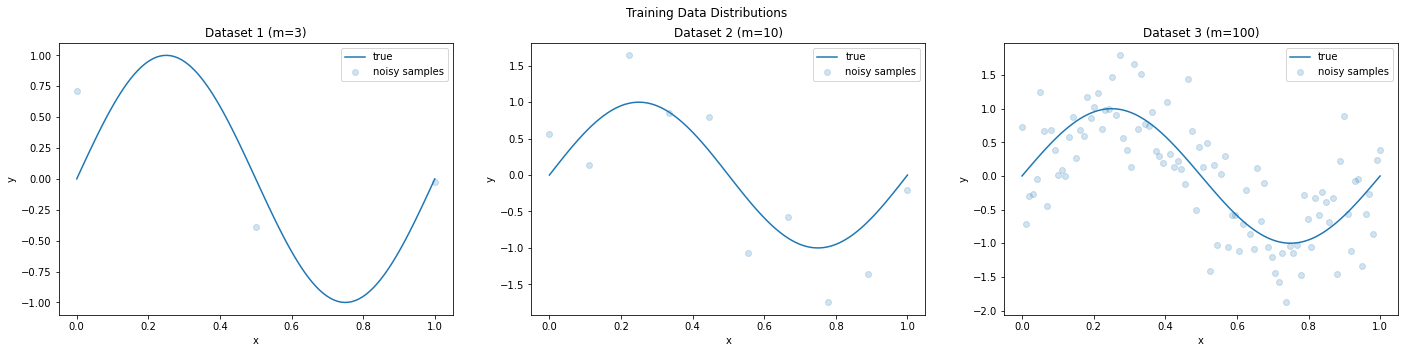

In [3]:
sample_sizes = [3, 10, 100]

mu_err = 0
var_err = 0.3

seed = 7
key = random.PRNGKey(seed)

fig, axs = plt.subplots(1, 3, figsize=(24, 5))
fig.suptitle('Training Data Distributions')

X_datasets = []
y_datasets = []

x = np.linspace(0, 1, 100)
y_true = np.sin(2*np.pi*x)

for i, m in enumerate(sample_sizes):
    # X = random.uniform(key, shape=(m,))
    X = np.linspace(0, 1, m)

    key, subkey = random.split(key)
    eps = np.sqrt(var_err) * random.normal(key, shape=(m,)) + mu_err

    y = np.sin(2 * np.pi * X) + eps

    X_datasets.append(X)
    y_datasets.append(y)

    axs[i].plot(x, y_true, label='true')
    axs[i].scatter(X, y, alpha=0.2, label='noisy samples')
    axs[i].set_title('Dataset {} (m={})'.format(i + 1, m))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].legend()

Generate Transformed Data and Find Best Complexity (Lowest Test Loss)

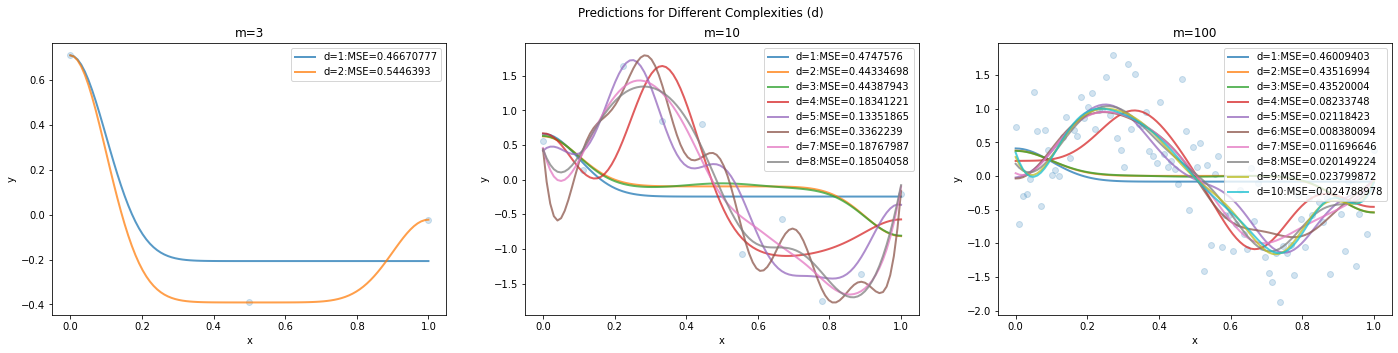

In [4]:
max_degrees = [2, 8, 10]
gaussRBF_var = 0.1

mu_err = 0
var_err = 0.3
gaussRBF_var = 0.1

fig, axs = plt.subplots(1, 3, figsize=(24, 5))
fig.suptitle('Predictions for Different Complexities (d)')

for i, X in enumerate(X_datasets):
    y = y_datasets[i]
    axs[i].scatter(X, y, alpha=0.2)

    for j in range(1, max_degrees[i] + 1):
        X_test = GaussianRBF(x, j, 0, 1, gaussRBF_var, biases=True)
        A = GaussianRBF(X, j, 0, 1, gaussRBF_var, biases=True)
        W = np.linalg.inv(np.matmul(A.T, A)).dot(A.T.dot(y[:, None]))
        # y_hat = np.matmul(A, W)
        y_hat = np.matmul(X_test, W)
        # loss = np.mean((y[:, None] - y_hat)**2)
        loss = np.mean((y_true[:, None] - y_hat)**2)
        axs[i].plot(x, y_hat, label= 'd=' + str(j) + ':' + 'MSE=' + str(loss), linewidth=2, alpha=0.75)

    axs[i].set_title('m=' + str(sample_sizes[i]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].legend()

We choose complexities d=2 for m=3, d=5 for m=10, and d=6 for m=100. Given the result obtained, higher degrees of complexity overfit the data significantly.

## Question 2: Online SGD

In [5]:
best_degrees = [2, 5, 6]

X_datasets_transformed = []
for i, X in enumerate(X_datasets):
    A = GaussianRBF(X, best_degrees[i], 0, 1, gaussRBF_var)
    X_datasets_transformed.append(A)

Loss Function

In [6]:
def Loss(X, w, b, y):
    y_hat = X.dot(w) + b
    return ((y_hat - y)**2).mean()

Online Learning

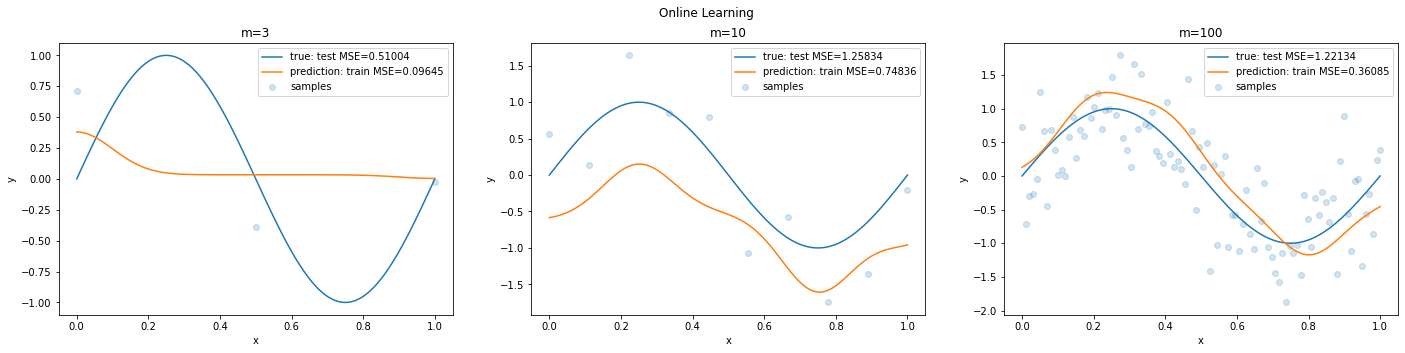

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
fig.suptitle('Online Learning')

for i, X_train in enumerate(X_datasets_transformed):
    w = np.zeros((X_train.shape[1], 1))
    b = 0.

    y_train = y_datasets[i][:, None]
    X_test = GaussianRBF(x, best_degrees[i], 0, 1, gaussRBF_var)

    learning_rate = 0.2

    r = np.array(range(X_train.shape[0]))
    key, subkey = random.split(key)
    r = random.permutation(key, r, independent=True)

    for j in r:
        w -= learning_rate * grad(Loss, argnums=1)(X_train[j], w, b, y_train[j])
        b -= learning_rate * grad(Loss, argnums=2)(X_train[j], w, b, y_train[j])

    tr_loss = Loss(X_train, w, b, y_train).item()
    tr_loss = round(tr_loss, 5)
    # y_hat = X_train.dot(w) + b
    y_hat = X_test.dot(w) + b
    ts_loss = np.mean((y_true - y_hat)**2).item()
    ts_loss = round(ts_loss, 5)

    axs[i].plot(x, y_true, label='true: test MSE={}'.format(ts_loss))
    axs[i].scatter(X_datasets[i], y_train, label='samples', alpha=0.2)
    axs[i].plot(x, y_hat, label='prediction: train MSE={}'.format(tr_loss), color='#ff7f0e')

    axs[i].set_title('m=' + str(X_train.shape[0]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].legend()

Gradient Descent is vary noisy and for large datasets can vary drastically depending on the order in which the samples are received.

## Question 3: Online Bayesian Regression

In Bayesian Regression, we learn the distribution of the model parameters through the application of Bayes' Rule. We consider prior and likelihood

$p(\theta)=\mathcal{N}(m_0, S_0)$

$p(y|x,\theta)=\mathcal{N}(y|\Phi\theta, \sigma^2 I)$

The posterior has a closed form solution 

$p(\theta|\mathcal{X}, \mathcal{Y})=\mathcal{N}(\theta|m_N, S_N)$

Where $m_N$ and $S_N$ are calculated through

$S_N = (S^{-1}_0 + \sigma^{-2}\Phi^T\Phi)^{-1}$

$m_N = S_N (S^{-1}_0 m_0 + \sigma^{-2}\Phi^T y)$

In the code, $S_N$ is what we call w_cov, which is the inverse matrix of w_precision. The regression parameters (w_mean in the code) correspond to vector $m_N$. $S_0$ and $m_0$ correspond to the prior values of $S_N$ and instead $m_N$, which are the new, updated values. We use the values of the posterior, as the values of the prior for the next calulation. The final values of $m_N$ and $S_N$ are the means and covariance matrix of the distribution of the parameters and $m_N$ corresponds to our maximum a posteriori prediction for our model parameters.

We compute the our noise free predictions as the expectation of the posterior distribution, which simplifies to

$E[f(\phi(x_*)|X, Y]=\phi^T(x_*)m_N$

The variance over the parameter distibution is instead calculated through

$V_{\theta}[f(x_*)|X, Y]=\phi^T(x_*) S_N \phi(x_*)$



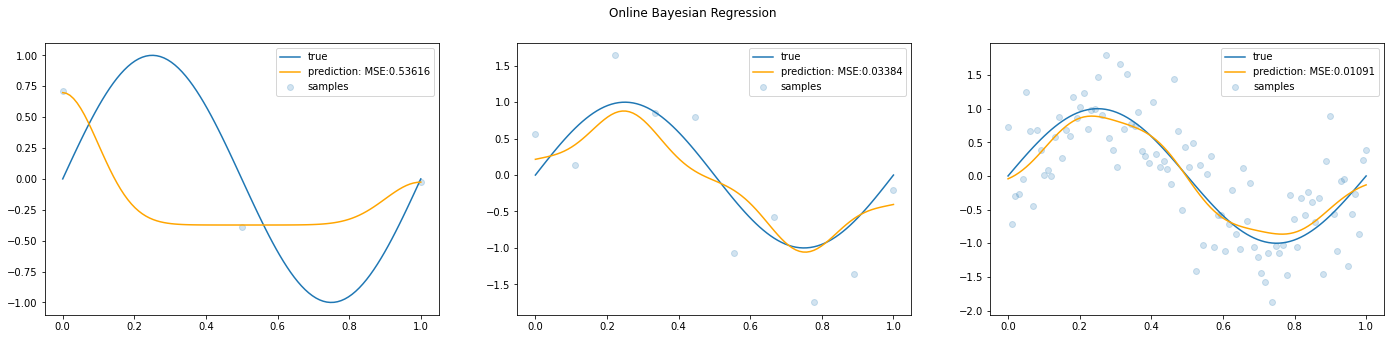

In [8]:
best_degrees = [2, 5, 6]

X_datasets_transformed = []
for i, X in enumerate(X_datasets):
    y = y_datasets[i]
    A = GaussianRBF(X, best_degrees[i], 0, 1, gaussRBF_var, biases=True)
    X_datasets_transformed.append(A)


alphas = [0.01, 1., 1.]
beta = 1.

fig, axs = plt.subplots(1, 3, figsize=(24, 5))
fig.suptitle('Online Bayesian Regression')

for i, X_train in enumerate(X_datasets_transformed):
    alpha = alphas[i]
    y_train = y_datasets[i]
    X_test = GaussianRBF(x, best_degrees[i], 0, 1, gaussRBF_var, biases=True)

    ndim = np.size(X_train, 1)
    mean_prev = np.zeros(ndim)
    precision_prev = alpha * np.eye(ndim)

    r = np.array(range(X_train.shape[0]))
    key, subkey = random.split(key)
    r = random.permutation(key, r, independent=True)

    for j in r:
        w_precision = precision_prev + beta * X_train[j:j+1].T @ X_train[j:j+1]
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + beta * X_train[j:j+1].T @ y_train[j:j+1],
        )
        w_cov = np.linalg.inv(w_precision)

        mean_prev = w_mean
        precision_prev = w_precision
    
    y_pred = X_test @ w_mean
    ts_loss = np.mean((y_true - y_pred)**2).item()
    ts_loss = round(ts_loss, 5)

    axs[i].scatter(X_datasets[i], y_train, label='samples',  alpha=0.2)
    axs[i].plot(x, y_true, label='true')
    axs[i].plot(x, y_pred, color="orange", label='prediction: MSE:{}'.format(ts_loss))
    axs[i].legend()

We can see that in small regimes, the bayesian approach is much better in the online setting than the MLE with SGD approach, with the appropriate tuning of the alpha parameter. This is because the bayesian approach inherently holds prior knowledge about the previous datapoints through the prior/posterior update. On the other side, online SGD relies exclusively on the information provided by a single data point at each computation of the gradient. The point on which the gradient is calculated might not yield the most optimal solution for all points making it inherently very noisy and possibly leading to suboptimal solutions, particularly in the small sample size regime. Hence, for the online setting, a bayesian approach seems to yield for robust paramter estimation.



#### Predictive Distribution (for m=10)

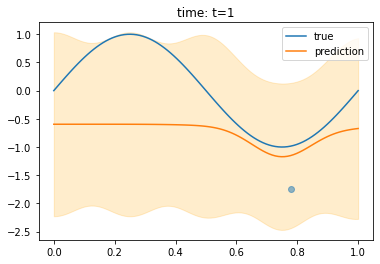

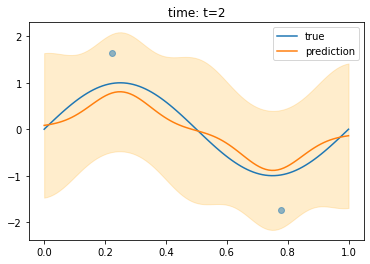

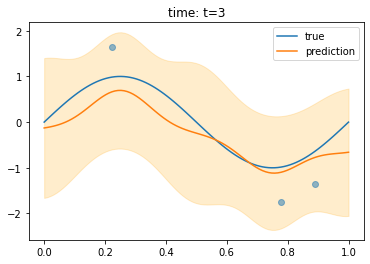

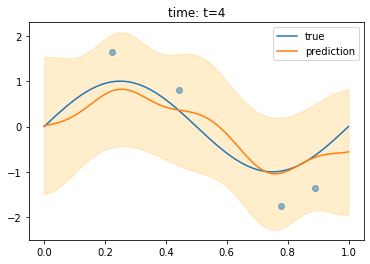

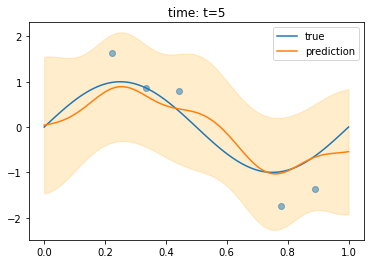

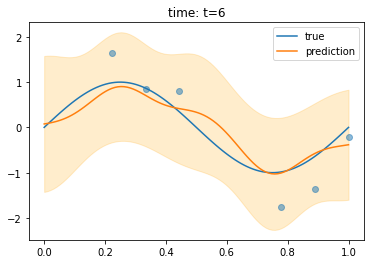

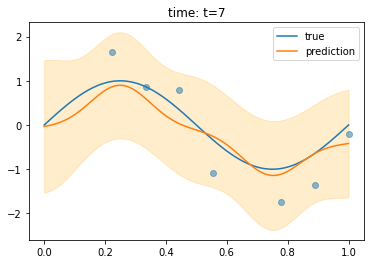

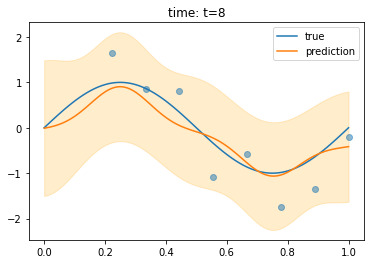

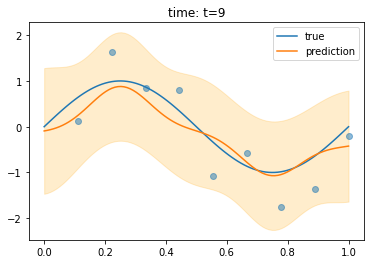

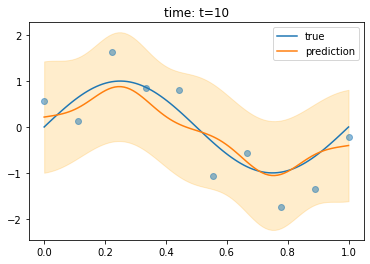

In [9]:
alpha = 1
beta = 1.

dataset_index = 1

X_train = X_datasets_transformed[dataset_index]
y_train = y_datasets[dataset_index]
X = X_datasets[dataset_index]

X_test = GaussianRBF(x, best_degrees[dataset_index], 0, 1, gaussRBF_var, biases=True)

ndim = np.size(X_train, 1)
mean_prev = np.zeros(ndim)
precision_prev = alpha * np.eye(ndim)

r = np.array(range(X_train.shape[0]))
key, subkey = random.split(key)
r = random.permutation(key, r, independent=True)
j = 0

for i in r:
    w_precision = precision_prev + beta * X_train[i:i+1].T @ X_train[i:i+1]
    w_mean = np.linalg.solve(
        w_precision,
        precision_prev @ mean_prev + beta * X_train[i:i+1].T @ y_train[i:i+1],
    )
    w_cov = np.linalg.inv(w_precision)

    mean_prev = w_mean
    precision_prev = w_precision

    y_pred = X_test @ w_mean

    y_var = 1 / beta + np.sum(X_test @ w_cov * X_test, axis=1)
    y_std = np.sqrt(y_var)

    plt.plot(x, y_true, label='true')
    plt.plot(x, y_pred, label='prediction')
    plt.fill_between(x, y_pred - y_std, y_pred + y_std, color="orange", alpha=0.2)
    plt.scatter(X[r[:j+1]], y_train[r[:j+1]], alpha=0.5)
    plt.title('time: t={}'.format(j+1))
    plt.legend()
    plt.show()
    j += 1

The posterior distribution of the parameters decreases in variance the more we train our model, converging slowly toward towards a specific set of weights.

### Question 4: Error vs. Model Complexity

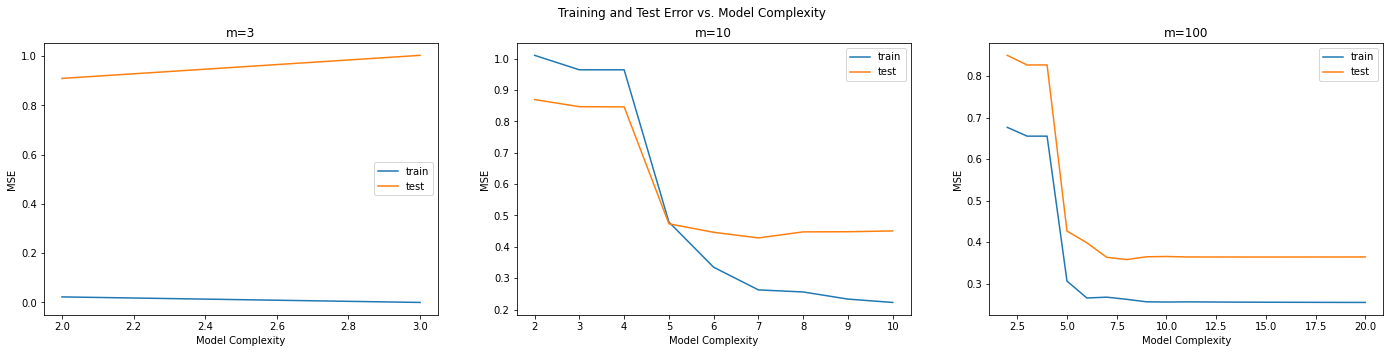

In [10]:
from numpy import degrees
alpha = 1
beta = 1.

x_test = np.linspace(0, 1, 50)
key, subkey = random.split(key)
eps = np.sqrt(var_err) * random.normal(key, shape=(50,)) + mu_err
y_test = np.sin(2 * np.pi * x_test) + eps

max_degrees = 20

fig, axs = plt.subplots(1, 3, figsize=(24, 5))
fig.suptitle('Training and Test Error vs. Model Complexity')

for i, X in enumerate(X_datasets):
    y_train = y_datasets[i]
    X = X_datasets[i]

    tr_losses = []
    ts_losses = []

    degrees = np.min(np.array([max_degrees, X.shape[0]]))
    alpha = alphas[i]

    for j in range(1, degrees):
        X_train = GaussianRBF(X, j, 0, 1, gaussRBF_var, biases=True)
        X_test = GaussianRBF(x_test, j, 0, 1, gaussRBF_var, biases=True)

        ndim = np.size(X_train, 1)
        mean_prev = np.zeros(ndim)
        precision_prev = alpha * np.eye(ndim)

        r = np.array(range(X_train.shape[0]))
        key, subkey = random.split(key)
        r = random.permutation(key, r, independent=True)

        for k in r:
            w_precision = precision_prev + beta * X_train[k:k+1].T @ X_train[k:k+1]
            w_mean = np.linalg.solve(
                w_precision,
                precision_prev @ mean_prev + beta * X_train[k:k+1].T @ y_train[k:k+1],
            )
            w_cov = np.linalg.inv(w_precision)

            mean_prev = w_mean
            precision_prev = w_precision
        
        y_pred = X_train @ w_mean
        tr_loss = np.mean((y_pred - y_train)**2)
        tr_losses.append(tr_loss)

        y_pred = X_test @ w_mean
        ts_loss = np.mean((y_pred - y_test)**2)
        ts_losses.append(ts_loss)

    axs[i].plot(range(2, degrees + 1), tr_losses, label='train')
    axs[i].plot(range(2, degrees + 1), ts_losses, label='test')

    axs[i].set_title('m={}'.format(sample_sizes[i]))
    axs[i].set_xlabel('Model Complexity')
    axs[i].set_ylabel('MSE')

    axs[i].legend()

Ignoring the results for the m=3 case, which is trivial, for the m=10 and m=100 case we can see the the best model complexity for our Bayesian model is 7. Higher complexity models overfit slightly the model.